# 4. 이미지 어디까지 우려볼까?

augmentation 기법을 적용해서 ResNet-50를 학습시켜보자. 텐서플로우의 random augmentation API 사용과 최신 augmentation 기법을 적용하고, 적용 유무에 따라 모델의 성능의 차이까지 알아보자.

# 4-2. Augmentation 적용(1) 데이터 불러오기

지금까지 모델을 훈련시키기 전, 데이터 전처리해서 사용했다.   
Augmentation도 입력 이미지의 데이터를 변경해 주는 과정이므로 일반적인 데이터 전처리와 활용 방법이 동일하다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


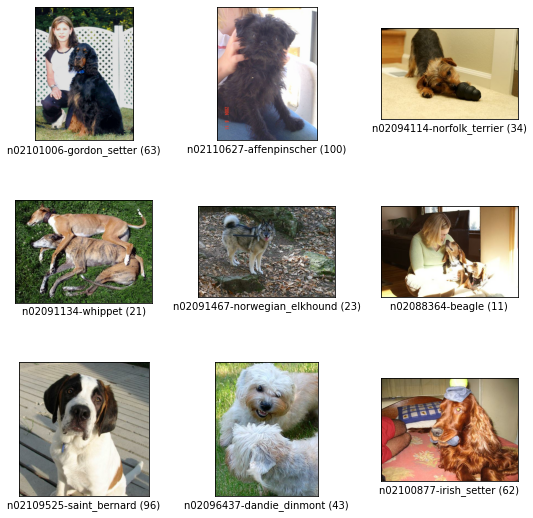

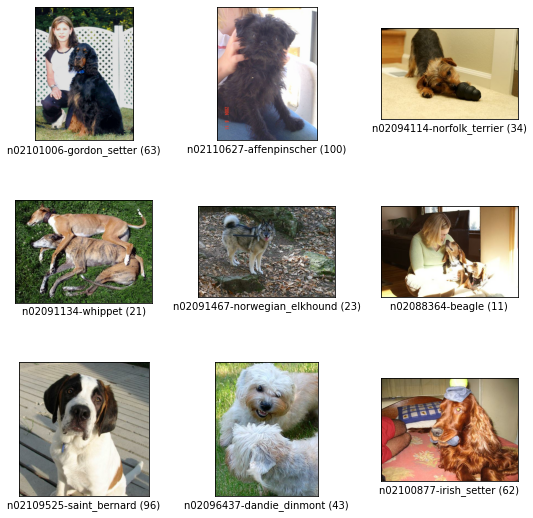

In [4]:
tfds.show_examples(ds_train, ds_info)

`stanford_dogs` 데이터셋을 사용해보자.   
120개의 견종과 총 20,580장의 이미지 중 12,000장은 train, 8580장은 test용으로 split 되어있다.

# 4-3. Augmentation 적용(2) Augmentation 적용하기

### 텐서플로우 Random augmentation API 사용하기
많은 augmentation 기법이 있는데, 그중 텐서플로우 API를 바로 사용할 수 있는 방법들을 적용해보자.   
랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들을 알아보자.
- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


이미지 전처리 함수이다. 입력받은 이미지를 0~1 사이의 float32로 normalize하고 (224,224) 크기로 resize한다.

위에서 언급한 random augmentation들 중 `flip_left_right()`, `brightness()`를 활용해보자.

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1) # brightness로 변한 image 텐서 값을 0~1 사이로 맞춘다.
    return image, label

print('=3')

=3


이렇게 원본 데이터셋을 가공한 후 새로운 데이터셋을 얻는 과정을 함수 `apply_normalize_on_dataset()`으로 정의하자.   
해당 함수를 통해 normalize, resize, augmentation과 shuffle을 적용하자. 단 shuffle, augmentation은 테스트 데이터셋에는 적용하면 안된다.

여러 결과를 조합하기 위한 ensemble 방법 중 하나로 테스트 데아터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있다.   
[TTA(test time augmentation) with 케라스](https://hwiyong.tistory.com/215)

비교 실험을 위해 `with_aug` 매개변수를 통해 augmentation의 적용 여부를 결정할 수 있도록 하자.

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2 # 병렬 처리
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


### Random augmentation 직접 구현하기
다른 augmentation 기법을 사용해서 `augment()` 함수처럼 작성해보자.

In [8]:
def augemnt2(image,label):
    image = tf.image.random_jpeg_quality(image, 60, 95) # image,min,max quality
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image,label

# 4-4. Augmentation 적용(3) 비교실험 하기

augmentation을 적용한 데이터를 학습한 모델과 그렇지 않은 모델의 성능을 비교해보자.   
새로운 augmentation의 적용 유무에 대한 효과 실험도 할 수 있다.

아래 코드는 keras의 ResNet50중 imagenet으로 훈련된 모델을 불러온다. `imclude_top`은 마지막 FC layer 포함 여부이다.   
해당 레이어를 포함하지 않고 생성하면 feature extractor 부분만 불러와 우리의 필요에 맞게 수정된 FC layer를 붙여 활용할 수 있다.   
이렇게 하는 이유는 ImageNet과 우리의 test set이 서로 다른 클래스를 가지므로, 마지막에 추가해야하는 FC layer의 구조 또한 다르기 때문이다.

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


하나는 `apply_normalize_on_datset()`에서 `with_aug`를 `False`값을 주어 augmentation을 적용하지 않고, 하나는 `True`값을 주어 적용되도록 하자

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


> augmentation 적용 효과를 명확히 검증하기 위해 20 EPOCH 정도는 해야한다. 하지만 원활한 학습 진행을 위해 3으로 진행해보자.

In [14]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 107s 130ms/step - loss: 2.1884 - accuracy: 0.4485 - val_loss: 3.0915 - val_accuracy: 0.2510
Epoch 2/3
750/750 [==============================] - 92s 122ms/step - loss: 0.7108 - accuracy: 0.7999 - val_loss: 1.2188 - val_accuracy: 0.6476
Epoch 3/3
750/750 [==============================] - 92s 122ms/step - loss: 0.2266 - accuracy: 0.9529 - val_loss: 0.9550 - val_accuracy: 0.7207


In [15]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/3
750/750 [==============================] - 112s 125ms/step - loss: 2.3099 - accuracy: 0.4259 - val_loss: 2.7313 - val_accuracy: 0.3082
Epoch 2/3
750/750 [==============================] - 95s 127ms/step - loss: 0.9394 - accuracy: 0.7296 - val_loss: 1.1932 - val_accuracy: 0.6472
Epoch 3/3
750/750 [==============================] - 95s 127ms/step - loss: 0.4837 - accuracy: 0.8698 - val_loss: 1.2081 - val_accuracy: 0.6560


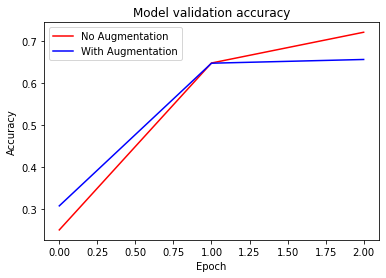

In [16]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

시각화를 좀 더 확대해서 살펴보자.

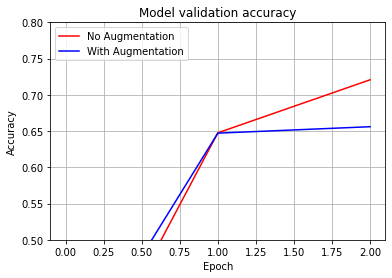

In [17]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

`EPOCH=20` 으로 수행한 결과를 보면 다음과 같다.   

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-2-P-result01.png)

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-2-P-result02.png)

처음에는 augmentation을 적용한 결과물의 accuracy가 낮았다가 시간이 지나면서 차츰 좋아지는걸 볼 수 있다.   
그리고 20epoch의 결과물을 보면 augmentation을 적용한 모델의 accuracy가 더 높게 나왔다.

# 4-5. 심화 기법(1) CutMix augmentiaton

조금 더 복잡한 __CutMix__ augmentation을 알아보자.   
- [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
- [Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook)

CutMix는 네이버 클로바(CLOVA)에서 발표한   
CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-2.max-800x600.png)

ResNet-50 column은 우리가 일반적으로 사용한 방식을 나타낸다. Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식이다. CutMix는 일정 영역을 잘라서 붙여주는 방법이다.

위 링크의 `CutMix and MixUp on GPU/TPU`에서 CutMix와 Mixup을 확인할 수 있다.   
CutMix는 이미지 섞는 부분과, 이미지에 맞춰 라벨을 섞어준다.

### 1) 이미지 섞기
두 개의 이미지를 섞는 것부터 생각해보자. 배치 내의 이미지를 두 개 골라서 섞어준다. 이때 이미지에서 잘라서 섞는 영역을 bounding box라고 부른다.

예시를 확인해보자.   
train dataset에서 이미지 2개를 가져와 랜덤하게 바운딩 박스 위치를 뽑고 잘라내서 섞어주는 함수이다.

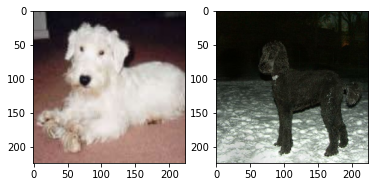

In [19]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

위 함수를 통해 얻은 `image_a`를 바탕으로 하고 거기에 삽입할 `image_b`를 넣어야 하는 작업이 필요하다.   

In [20]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(78, shape=(), dtype=int32) tf.Tensor(214, shape=(), dtype=int32)
y :  tf.Tensor(12, shape=(), dtype=int32) tf.Tensor(169, shape=(), dtype=int32)


삽입할 이미지의 바운딩 박스 위치를 결정하는 함수 `get_clip_box()`이다.

`stanford_dogs` 데이터셋 이미지를 224, 224로 resize 전처리를 해주었기 때문에 width, height가 같지만, CutMix 공식 repo에서는 이미지 사이즈가 다르더라도 가변적으로 적용할 수 있도록 구현되어있다. 그래서 동일하게 구현했다.

그리고 `image_a`에서 바운딩 박스 바깥 영역, 다른 `image_b`에서 바운딩 박스 안쪽 영역을 가져와 합치는 함수를 구현하자.

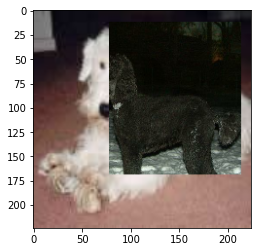

In [21]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기

이미지를 섞었다면 라벨도 섞어주어야한다. 단 이미지를 섞은만큼 라벨도 저적한 비율로 섞어야한다.

CutMix는 면적에 비례해서 라벨을 섞어준다. `섞인 이미지 / 전체 이미지` 비율을 계산해서 두 가지 라벨의 비율로 더해준다.   
A 클래스를 가진 원래 이미지 `image_a` 40%와 B 클래스를 가진 `image_b` 60%를 섞는다면, 라벨 벡터를 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가진 원-핫 인코딩 방식이 아니라 A와 B클래스에 해당하는 인덱스에 0.4, 0.6을 배분하는 방식이다.

In [22]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.5744579, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

위에서 구현한 `mix_2_images()`, `mix_2_label()`을 활용하여 배치 단위의 `cutmix()` 함수를 구현해보자.

In [23]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# 4-6. 심화 기법(2) Mixup augmentation

Mixup은 CutMix보다 간단하게 이미지와 라벨을 섞는다.   
두 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-3.max-800x600.png)

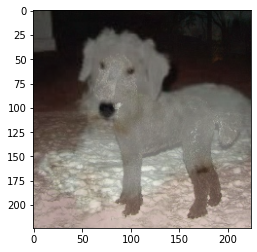

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.4983467 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [24]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [25]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# 4-7. 프로젝트

CutMix, Mixup을 적용해 모델을 훈련시켜보자. 결과를 수치화하고 비교까지 해보자.